# Imports and Declarations

In [ ]:
%tensorflow_version 2.x

In [ ]:
#import libraries
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
%matplotlib inline

In [ ]:
#weight_path = '/content/drive/MyDrive/pre models/inception_v3_weights_tf_dim_ordering_tf_kernels.h5'
train_data_path = '/content/GenderClassifierDataset/Training/'
val_data_path = '/content/GenderClassifierDataset/Validation/'

In [ ]:
epochs = 50
lr = 0.0001
batch_size = 512
data = []
label = []
size = 256

# Image Data Processing

In [ ]:
train_dp = ImageDataGenerator(horizontal_flip=True,
                              width_shift_range=0.4,
                              height_shift_range=0.4,
                              zoom_range=0.3,
                              rotation_range=20,
                              rescale=1.0/255)
val_dp = ImageDataGenerator(rescale=1/255)
train_result = train_dp.flow_from_directory(directory=train_data_path,
                             target_size=(256, 256),
                             batch_size=batch_size,
                             class_mode='binary',
                             )

Found 89443 images belonging to 2 classes.


In [ ]:
val_result = val_dp.flow_from_directory(directory=val_data_path,
                             target_size=(256, 256),
                             batch_size=batch_size,
                             class_mode='binary',
                             )

Found 20714 images belonging to 2 classes.


In [ ]:
X_train, y_train = next(train_result)
X_test, y_test = next(val_result)

In [ ]:
print(train_result.class_indices)

{'female': 0, 'male': 1}


# Inception V3

In [ ]:
from keras_tuner import HyperModel

class RegressionHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape 

    def build(self, hp):
        model = Sequential()
        model.add(InceptionV3(include_top=False,
                      pooling='avg',
                      weights='imagenet'))
        model.add(Flatten())
        model.add(BatchNormalization())

        model.add(Dense(2048, activation='relu'))
        model.add(BatchNormalization())

        model.add(
            Dense(
                units=hp.Int('units', 32, 2048, 2, default=1024),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
                input_shape=input_shape
            )
        )
        model.add(BatchNormalization())

        model.add(
            Dense(
                units=hp.Int('units', 32, 2048, 2, default=1024),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu')
            )
        )
        model.add(BatchNormalization())


        model.add(
            Dropout(
                hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.1,
                    default=0.005,
                    step=0.01)
            )
        )

        model.add(Dense(1, activation='sigmoid'))
        model.layers[0].trainable=False
        
        model.compile(loss='binary_crossentropy', 
                      optimizer='Adam', 
                    metrics=['accuracy'])
        
        return model

In [ ]:
import keras_tuner as kt
input_shape = (X_train.shape[1],)
hypermodel = RegressionHyperModel(input_shape)

#Random Search

In [ ]:
tuner_rs = kt.RandomSearch(
            hypermodel,
            objective='val_accuracy',
            max_trials=20,
            executions_per_trial=10)
tuner_rs.search(X_train, y_train, epochs=50, validation_split=0.2, verbose=0)
rs_best_model = tuner_rs.get_best_models(num_models=1)[0]
rs_best_model.evaluate(X_test, y_test)

87924736/87910968 [==============================] - 1s 0us/step
INFO:tensorflow:Oracle triggered exit
16/16 [==============================] - 3s 65ms/step - loss: 1.3334 - accuracy: 0.7109


[1.3334014415740967, 0.7109375]

In [ ]:
rs_best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_95 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 320)               655680    
_________________________________________________________________
batch_normalization_96 (Batc (None, 320)               1

#Bayesian Optimization

In [ ]:
tuner_bo = kt.BayesianOptimization(
            hypermodel,
            objective='val_accuracy',
            max_trials=20,
            executions_per_trial=10
        )
tuner_bo.search(X_train, y_train, epochs=50, validation_split=0.2, verbose=0)
bo_best_model = tuner_bo.get_best_models(num_models=1)[0]
bo_best_model.evaluate(X_test, y_test)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
bo_best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 1548)              3171852   
_________________________________________________________________
batch_normalization_95 (Batc (None, 1548)              6192      
_________________________________________________________________
dense_1 (Dense)              (None, 1548)              2397852   
_________________________________________________________________
batch_normalization_96 (Batc (None, 1548)              6

#Saving Model

In [ ]:
# checkpoint
filepath= '/content/drive/MyDrive/Gender Model/gender_class_modelKT.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
train_result

In [ ]:
rs_best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_95 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 320)               655680    
_________________________________________________________________
batch_normalization_96 (Batc (None, 320)               1

In [ ]:
history = rs_best_model.fit(train_result, steps_per_epoch=len(train_result.filenames)//batch_size,
          epochs=epochs, validation_data=val_result,
          callbacks=callbacks_list,
          validation_steps=len(val_result.filenames)//batch_size
)

Epoch 1/50
174/174 [==============================] - 1340s 8s/step - loss: 0.5319 - accuracy: 0.7593 - val_loss: 0.3732 - val_accuracy: 0.8314

Epoch 00001: val_accuracy improved from -inf to 0.83140, saving model to /content/drive/MyDrive/Gender Model/gender_class_modelKT.hdf5
Epoch 2/50
174/174 [==============================] - 1273s 7s/step - loss: 0.4284 - accuracy: 0.8004 - val_loss: 0.3337 - val_accuracy: 0.8557

Epoch 00002: val_accuracy improved from 0.83140 to 0.85571, saving model to /content/drive/MyDrive/Gender Model/gender_class_modelKT.hdf5
Epoch 3/50
174/174 [==============================] - 1260s 7s/step - loss: 0.4095 - accuracy: 0.8127 - val_loss: 0.3713 - val_accuracy: 0.8252

Epoch 00003: val_accuracy did not improve from 0.85571
Epoch 4/50
174/174 [==============================] - 1260s 7s/step - loss: 0.3977 - accuracy: 0.8165 - val_loss: 0.3278 - val_accuracy: 0.8563

Epoch 00004: val_accuracy improved from 0.85571 to 0.85630, saving model to /content/drive/M

In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


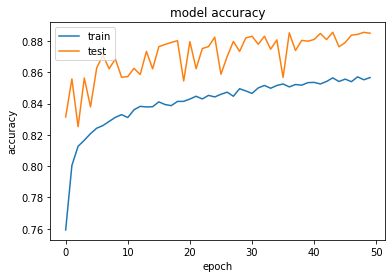

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

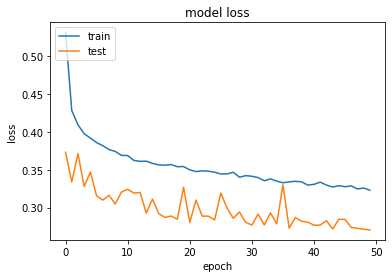

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Test Model

In [ ]:
# load weights
model.load_weights("/content/drive/MyDrive/All_Models/gender_class_model.hdf5")

In [ ]:
def get_classes(data):
    prob = model.predict(img)[0][0]
    
    if prob<=0.5:
        return 'female', 1-prob
    else:
        return 'male', prob

In [ ]:
import os
import shutil
import cv2
img_path = '/content/test_data/'

female 0.9835036732256413


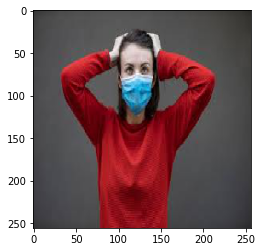

male 0.8502522


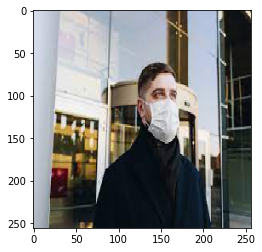

female 0.5594784915447235


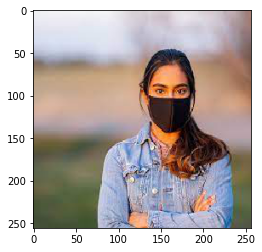

female 0.5272960066795349


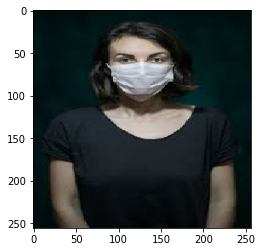

female 0.9782365970313549


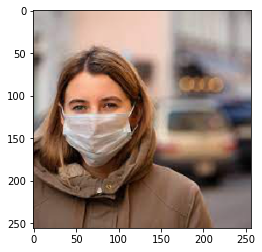

In [ ]:
for im in os.listdir(img_path):
    img = load_img(img_path+im, target_size=(256, 256, 3))
    plt.imshow(img) 
    img = img_to_array(img)
    img = img/255.0
    #print(img.shape)
    img = img.reshape(1, 256, 256, 3)
    model.predict(img)
    (pred, prob) = get_classes(img)
    print(pred, prob)
    plt.show()
    '''
    if (pred =='female'):
        shutil.move(img_path+im, '/content/MaskData2/female/'+im)
    else:
        shutil.move(img_path+im, '/content/MaskData2/male/'+im)
    '''